In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import sys
print(sys.executable)

/cluster/home/9339yk/ml23_fmri_group_20a/venv/bin/python


In [3]:
!jupyter kernelspec list

Available kernels:
  python3    /cluster/home/9339yk/ml23_fmri_group_20a/venv/share/jupyter/kernels/python3


In [4]:
import glob
import random
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from skimage import color
from skimage import io
from skimage.transform import resize
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython import display
import pathlib
from tensorflow import keras
import datetime
import time
import cv2

2023-12-17 05:25:03.669932: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 05:25:03.669969: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 05:25:03.675396: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 05:25:04.206773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 05:25:06.499930: W tensorflow/compiler/

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        print('enable gpu')
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

enable gpu
1 Physical GPUs, 1 Logical GPUs


2023-12-17 05:25:10.746696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-17 05:25:11.729369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-17 05:25:11.729585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
ROOT_FILE_PATH = "REAL"
AREAS = ["prf-visualrois", "floc-bodies", "floc-faces", "floc-places", "floc-words", "streams", "all-vertices"]
MASK_KEYS = ["lh.fsaverage_space", "rh.fsaverage_space", "lh.space", "rh.space", "mapping"]

In [7]:
def ReadNpyFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename] = np.load(path, allow_pickle = True)
  return return_dic

def ReadFmriFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename[0]] = np.load(path, allow_pickle = True)
  return return_dic

def ReadMaskFile(dir_path):
  return_dic = {area: {} for area in AREAS}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    for area in AREAS:
      if area in filename:
        filename = "".join(i.strip("_") for i in filename.split(area))
        return_dic[area][filename] = np.load(path, allow_pickle = True) if filename[0] != "m" else np.load(path, allow_pickle = True).item()
        break
  return return_dic

def FetchPngFile(dir_path, index, mode = "rgb"):
  # img = iio.v3.imread()
  img = io.imread(os.path.join(dir_path, f'{index}.png'))
  if mode == "rgb":
    return img
  if mode == "hsv":
    return color.rgb2hsv(img)
    # return matplotlib.colors.rgb_to_hsv(img)
  if mode == "gray":
    return color.rgb2gray(img)
    # return np.dot(img, [0.299, 0.587, 0.114])
  

In [8]:
def ApplyRoiMask(roi, fmri, mask):
    hemisphere = ["l", "r"]
    # Define the ROI class based on the selected ROI
    if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
        roi_class = 'prf-visualrois'
    elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
        roi_class = 'floc-bodies'
    elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
        roi_class = 'floc-faces'
    elif roi in ["OPA", "PPA", "RSC"]:
        roi_class = 'floc-places'
    elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
        roi_class = 'floc-words'
    elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
        roi_class = 'streams'
    result = {}
    print(type(mask))
    for items in hemisphere:
        _hfmri = fmri[items]
        roi_map = mask[roi_class]['mapping']
        challenge_roi_class = mask[roi_class][items+'h.space']
        roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
        challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
        result[items] = np.zeros(_hfmri.shape)
        result[items][:, np.where(challenge_roi)[0]] = _hfmri[:, np.where(challenge_roi)[0]]
    return result

In [9]:
def ApplyRoiMask(fmri, mask):
    hemisphere = ["l", "r"]
    # Define the ROI class based on the selected ROI
    roi_dic = {'prf-visualrois':["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"], 'floc-bodies':["EBA", "FBA-1", "FBA-2", "mTL-bodies"],
     'floc-faces':["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"],'floc-places':["OPA", "PPA", "RSC"], 
    'floc-words':["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"], 'streams':["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]}
    roi_focusing = {'prf-visualrois', 'floc-bodies', 'floc-places'}

    result = {}
    roi_map = {}
    # challenge_roi_class = []
    roi_mapping = {}
    challenge_roi = {'l':np.zeros(19004,), 'r':np.zeros(20544,)}
    # print(type(mask))
    masks = list(mask.keys())[:6]
    # print(masks)
    for items in hemisphere:
        _hfmri = fmri[items]
        for i,m in enumerate(roi_focusing):
            # print("mask[m]:", mask[m])
            # roi_map[m].append(mask[m]['mapping'])
            # for roi in roi_dic[m]:
                # print("mask[m]:",mask[m].keys())
                # roi_map[m].append(mask[m]['mapping'])
            challenge_roi_class = (np.asarray(mask[m][items+'h.space'], dtype=int))
                # print(roi_map[i].values())
                # print("m:, ", m, "roi_dic:", roi_dic[m])
                # for roi in roi_dic[m]:
                #     roi_mapping.append(list(roi_map[i].keys())[list(roi_map[i].values()).index(roi)])
            challenge_roi[items] = challenge_roi[items] + challenge_roi_class
        result[items] = np.zeros(_hfmri.shape)
        result[items][:, np.where(challenge_roi[items])[0]] = _hfmri[:, np.where(challenge_roi[items])[0]]
    return result

In [10]:
def train_val_split(x, y, ratio, random_state=42):
  
  r = np.random.RandomState(random_state)
  
  idx = r.permutation(x.index)
  x_per = x.reindex(idx)
  y_per = y.reindex(idx)

  train_size = int(x.shape[0] * ratio)
  
  x_train = x_per[0:train_size]
  y_train = y_per[0:train_size]
  
  x_val = x_per[train_size:]
  y_val = y_per[train_size:]
  
  print('Training_dimension: ' + str(x_train.shape) + ' | ' + str(y_train.shape))
  print('Validation_dimension: ' + str(x_val.shape) + ' | ' + str(y_val.shape))

  return x_train, x_val, y_train, y_val

In [11]:
class ReadObject:
  
  #fmri = None           # dict(string -> ndarray, float32)
  #masks = None          # dict(string "AREA" -> (dict(int -> string), string "HEMISPHERE, " -> ndarray))
  
  #image_labels = None   # dataframe
  #label_names = None    # list

  subject = None        # string
  
  def __init__(self, subject):
    self.subject = subject

  # Mode = "train" | "test"
  def load(self, mode="train", load_images=True, image_mode="gray", image_count=-1):
    
    loaded_fmri = None
    loaded_images = None
    
    image_labels = pd.read_csv(os.path.join(ROOT_FILE_PATH, "image_infos", f"{self.subject}_infos_train.csv"))
    image_labels = image_labels.drop(image_labels.columns[[0, 1]], axis=1)
    
    label_names = image_labels.columns
    
    image_labels = image_labels.to_numpy(dtype=int)
    
    masks = ReadMaskFile(os.path.join(ROOT_FILE_PATH, self.subject , "roi_masks"))
    
    if load_images:
      image_count = image_labels.shape[0] if image_count is -1 else image_count
      print(f'Images: {image_count} | Labels: {image_labels.shape[1]} | Masks: {len(masks.keys())}')
    else:
      print(f'Labels: {image_labels.shape[1]} | Masks: {len(masks.keys())}')
        
    if mode == "train":
      loaded_fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_fmri"))
      if load_images:
        
        print(f'Load {image_count} training images..')
        loaded_images = np.stack([
          FetchPngFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_images"), idx, mode = image_mode) for idx in range(image_count)
        ])
    elif mode == "test":
      loaded_fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "test_split", "test_fmri"))
      if load_images:
        
        print(f'Load {image_count} training images..')
        loaded_images = np.stack([
          FetchPngFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_images"), idx, mode = image_mode) for idx in range(image_count)
        ])
    return label_names, image_labels, masks, loaded_fmri, loaded_images

  def split_data(self, image_labels, fmri, images, split_ratio=None, permutate=True, count=None, random_state=42):
    
    idx_train, idx_val = None, None
    images_train, images_val = None, None
    labels_val, fmri_l_val, fmri_r_val = None, None, None
    
    if split_ratio is None:
      split_ratio = 1
    
    random_state = np.random.RandomState(random_state)
    
    if count is not None and count > 0:
      fmri_l_train = fmri['l'][:count]
      fmri_r_train = fmri['r'][:count]
      labels_train = image_labels[:count]
      if images is not None:
        images_train = images[:count]
    else:
      fmri_l_train = fmri['l']
      fmri_r_train = fmri['r']
      labels_train = image_labels
      if images is not None:
          images_train = images
        
    if permutate:
      
        idx_train = random_state.permutation(labels_train.shape[0])
        
        fmri_l_train = fmri_l_train[idx_train]
        fmri_r_train = fmri_r_train[idx_train]
        labels_train = labels_train[idx_train]
        if images_train is not None:
          images_train = images_train[idx_train]
    
    if split_ratio < 1.0:
      
      train_size = int(labels_train.shape[0] * split_ratio)
      
      idx_val = idx_train[train_size:]
      fmri_l_val = fmri_l_train[train_size:]
      fmri_r_val = fmri_r_train[train_size:]
      labels_val = labels_train[train_size:]
      if images_train is not None:
        images_val = images_train[train_size:]
  
      idx_train = idx_train[0:train_size]
      fmri_l_train = fmri_l_train[0:train_size]
      fmri_r_train = fmri_r_train[0:train_size]
      labels_train = labels_train[0:train_size]
      if images_train is not None:
        images_train = images_train[0:train_size]
    
    return (labels_train, labels_val), (fmri_l_train, fmri_l_val), (fmri_r_train, fmri_r_val), (images_train, images_val), (idx_train, idx_val)

<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_129561/2280006958.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  image_count = image_labels.shape[0] if image_count is -1 else image_count


In [12]:
SUBJ_LIST = ["subj01", "subj02", "subj04", "subj05", "subj07", "subj08"]#"subj03",

In [13]:
def min_max_normalize(data, min=0, max=1, dtype='float32'):
  
  # Define the original range
  old_min = np.min(data)
  old_max = np.max(data)
  
  # Map the values from the original range to the new range
  data = (np.array(data, dtype=dtype) - old_min) * (max - min) / (old_max - old_min) + min
  
  return data

In [14]:
%matplotlib inline
def showSingleImage(subject, index, image_mode='gray'):
  image = FetchPngFile(os.path.join(ROOT_FILE_PATH, subject, "training_split", "training_images"), index, mode=image_mode)
  plt.imshow(image, cmap='gray')
  plt.show()

# Free memory

In [15]:

global_labels_name = None
global_labels_train = None
global_labels_val = None
global_fmri_l_train = None
global_fmri_l_val = None
global_fmri_r_train = None
global_fmri_r_val = None
global_images_train = None
global_images_val = None
global_idx_train = None
global_idx_val = None

global_train_count = None
global_val_count = None

### Load subject train / val data

In [16]:
global_labels_name = None
global_labels_train = None
global_labels_val = None
global_fmri_l_train = None
global_fmri_l_val = None
global_fmri_r_train = None
global_fmri_r_val = None
global_images_train = None
global_images_val = None
global_idx_train = None
global_idx_val = None

global_train_count = None
global_val_count = None

load_mode= 'train'
subject_count = 5

image_mode = "gray"
image_count = 1000 # -1 for all or 0 for none or > 2 for images
load_images = image_count > 0 and load_mode == 'train'

fit_fmri_dimension = True
fit_fmri_target_size = 21025 # 145 x 145

for sub in SUBJ_LIST[:subject_count]:
  
  print(sub)
  
  sub_obj = ReadObject(sub)
  label_names, image_labels, masks, fmri, images = sub_obj.load(mode=load_mode, load_images=load_images, image_count=image_count)
  
  fmri = ApplyRoiMask(fmri, masks)
  global_labels_name = label_names if global_labels_name is None else global_labels_name
  
  count = None if images is None else images.shape[0]
  split_ratio = 0.99 if load_mode == 'train' else 1
  
  ((labels_train, labels_val), (fmri_l_train, fmri_l_val), (fmri_r_train, fmri_r_val), (images_train, images_val), (idx_train, idx_val)) = (
    sub_obj.split_data(image_labels, fmri, images, split_ratio=split_ratio, count=count, permutate= load_mode=='train'))
  
  global_train_count = labels_train.shape[0] if global_train_count is None else global_train_count
  global_val_count = labels_val.shape[0] if global_val_count is None else global_val_count

  global_idx_train = idx_train if global_idx_train is None else np.concatenate((global_idx_train, idx_train))
  if idx_val is not None:
    global_idx_val = idx_val if global_idx_val is None else np.concatenate((global_idx_val, idx_val))
  
  print(f"labels_train  shape: {labels_train.shape}")
  global_labels_train = labels_train if global_labels_train is None else np.vstack((global_labels_train, labels_train))
  
  if labels_val is not None:
    print(f"labels_val  shape: {labels_val.shape}")
    global_labels_val = labels_val if global_labels_val is None else np.vstack((global_labels_val, labels_val))
  
  print(fmri_l_train.shape)
  if fit_fmri_dimension:
    additional_rows = np.zeros(shape=(fmri_l_train.shape[0], fit_fmri_target_size - fmri_l_train.shape[1]))
    fmri_l_train = np.concatenate((fmri_l_train, additional_rows), axis=1)
  fmri_l_train = min_max_normalize(fmri_l_train) # fmri_l_train / np.max(fmri_l_train)
  print(f"fmri_l_train  shape: {fmri_l_train.shape} | min: {np.min(fmri_l_train)} max: {np.max(fmri_l_train)}")
  global_fmri_l_train = fmri_l_train if global_fmri_l_train is None else np.vstack((global_fmri_l_train, fmri_l_train))
  
  if fmri_l_val is not None:
    if fit_fmri_dimension:
      additional_rows = np.zeros(shape=(fmri_l_val.shape[0], fit_fmri_target_size - fmri_l_val.shape[1]))
      fmri_l_val = np.concatenate((fmri_l_val, additional_rows), axis=1)
    fmri_l_val = min_max_normalize(fmri_l_val) # fmri_l_val / np.max(fmri_l_val)
    print(f"fmri_l_val  shape: {fmri_l_val.shape} | min: {np.min(fmri_l_val)} max: {np.max(fmri_l_val)}")
    global_fmri_l_val = fmri_l_val if global_fmri_l_val is None else np.vstack((global_fmri_l_val, fmri_l_val))
  
  if fit_fmri_dimension:
    additional_rows = np.zeros(shape=(fmri_r_train.shape[0], fit_fmri_target_size - fmri_r_train.shape[1]))
    fmri_r_train = np.concatenate((fmri_r_train, additional_rows), axis=1)
  fmri_r_train = min_max_normalize(fmri_r_train) # fmri_r_train / np.max(fmri_r_train)
  print(f"fmri_r_train  shape: {fmri_r_train.shape} | min: {np.min(fmri_r_train)} max: {np.max(fmri_r_train)}")
  global_fmri_r_train = fmri_r_train if global_fmri_r_train is None else np.vstack((global_fmri_r_train, fmri_r_train))
  
  if fmri_r_val is not None:
    if fit_fmri_dimension:
      additional_rows = np.zeros(shape=(fmri_r_val.shape[0], fit_fmri_target_size - fmri_r_val.shape[1]))
      fmri_r_val = np.concatenate((fmri_r_val, additional_rows), axis=1)
    fmri_r_val = min_max_normalize(fmri_r_val) # fmri_r_val / np.max(fmri_r_val)
    print(f"fmri_r_val  shape: {fmri_r_val.shape} | min: {np.min(fmri_r_val)} max: {np.max(fmri_r_val)}")
    global_fmri_r_val = fmri_r_val if global_fmri_r_val is None else np.vstack((global_fmri_r_val, fmri_r_val))
  
  if load_images:
  
    if image_mode == 'rgb':
      images_train = images_train / 255. 
    elif image_mode == 'gray':
      images_train = images_train.reshape((-1, images_train.shape[1], images_train.shape[2], 1))
        
    print(f"images_train  shape: {images_train.shape} | min: {np.min(images_train)} max: {np.max(images_train)}")
    global_images_train = images_train if global_images_train is None else np.vstack((global_images_train, images_train))
    
    if image_mode == 'rgb':
      images_val = images_val / 255. 
    elif image_mode == 'gray':
      images_val = images_val.reshape((-1, images_val.shape[1], images_val.shape[2], 1))
        
    print(f"images_val  shape: {images_val.shape} | min: {np.min(images_val)} max: {np.max(images_val)}")
    global_images_val = images_val if global_images_val is None else np.vstack((global_images_val, images_val))
  
  # Free memory
  labels_train, labels_val, fmri_l_train, fmri_l_val, fmri_r_train, fmri_r_val, images_train, images_val = None, None, None, None, None, None, None, None
  label_names, image_labels = None, None
  additional_rows = None
  
  print('')

subj01
Images: 1000 | Labels: 133 | Masks: 7
Load 1000 training images..


labels_train  shape: (990, 133)
labels_val  shape: (10, 133)
(990, 19004)
fmri_l_train  shape: (990, 21025) | min: 0.0 max: 1.0
fmri_l_val  shape: (10, 21025) | min: 0.0 max: 1.0
fmri_r_train  shape: (990, 21025) | min: 0.0 max: 1.0
fmri_r_val  shape: (10, 21025) | min: 0.0 max: 1.0
images_train  shape: (990, 425, 425, 1) | min: 0.0 max: 1.0
images_val  shape: (10, 425, 425, 1) | min: 0.0 max: 1.0

subj02
Images: 1000 | Labels: 133 | Masks: 7
Load 1000 training images..
labels_train  shape: (990, 133)
labels_val  shape: (10, 133)
(990, 19004)
fmri_l_train  shape: (990, 21025) | min: 0.0 max: 1.0
fmri_l_val  shape: (10, 21025) | min: 0.0 max: 1.0
fmri_r_train  shape: (990, 21025) | min: 0.0 max: 1.0
fmri_r_val  shape: (10, 21025) | min: 0.0 max: 1.0
images_train  shape: (990, 425, 425, 1) | min: 0.0 max: 1.0
images_val  shape: (10, 425, 425, 1) | min: 0.0 max: 1.0

subj04
Images: 1000 | Labels: 133 | Masks: 7
Load 1000 training images..
labels_train  shape: (990, 133)
labels_val  shape:

In [17]:
print('Global train shapes:')
print("labels(train): ", global_labels_train.shape)
print("labels(val): ", global_labels_val.shape)
print("fmri_l(train): ", global_fmri_l_train.shape)
print("fmri_l(val): ",global_fmri_l_val.shape)
print("fmri_r(train): ",global_fmri_r_train.shape)
print("fmri_r(val): ",global_fmri_r_val.shape)
print("index(train): ", global_idx_train.shape)
print("index(val): ", global_idx_val.shape)

print(global_train_count)
print(global_val_count)

if load_images:
  print("images:")
  print(global_images_train.shape)
  print(global_images_val.shape)

Global train shapes:
labels(train):  (4950, 133)
labels(val):  (50, 133)
fmri_l(train):  (4950, 21025)
fmri_l(val):  (50, 21025)
fmri_r(train):  (4950, 21025)
fmri_r(val):  (50, 21025)
index(train):  (4950,)
index(val):  (50,)
990
10
images:
(4950, 425, 425, 1)
(50, 425, 425, 1)


Global train labels:
{'person': 2498, 'bicycle': 132, 'car': 509, 'motorcycle': 125, 'airplane': 152, 'bus': 193, 'train': 178, 'truck': 222, 'boat': 156, 'traffic light': 179, 'fire hydrant': 83, 'stop sign': 65, 'parking meter': 41, 'bench': 204, 'bird': 147, 'cat': 167, 'dog': 169, 'horse': 121, 'sheep': 54, 'cow': 99, 'elephant': 91, 'bear': 54, 'zebra': 78, 'giraffe': 129, 'backpack': 206, 'umbrella': 143, 'handbag': 246, 'tie': 120, 'suitcase': 84, 'frisbee': 83, 'skis': 129, 'snowboard': 69, 'sports ball': 174, 'kite': 94, 'baseball bat': 83, 'baseball glove': 85, 'skateboard': 126, 'surfboard': 191, 'tennis racket': 165, 'bottle': 373, 'wine glass': 104, 'cup': 347, 'fork': 117, 'knife': 173, 'spoon': 177, 'bowl': 354, 'banana': 91, 'apple': 73, 'sandwich': 87, 'orange': 63, 'broccoli': 98, 'carrot': 102, 'hot dog': 49, 'pizza': 143, 'donut': 62, 'cake': 101, 'chair': 447, 'couch': 161, 'potted plant': 167, 'bed': 160, 'dining table': 428, 'toilet': 135, 'tv': 156, 'laptop': 14

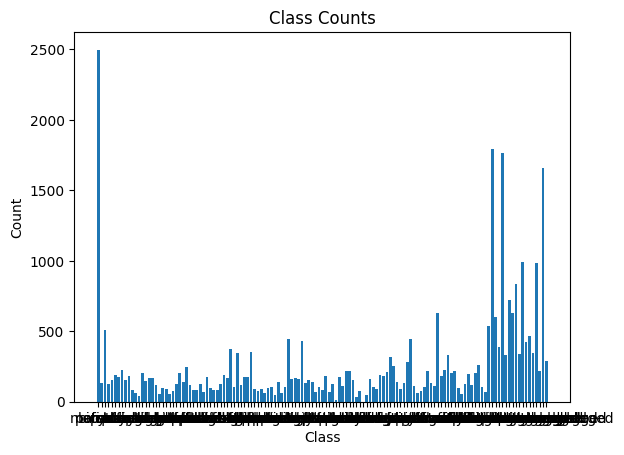

In [18]:
print(f'Global train labels:')
global_Y_train_classification = global_labels_train
count_categories = {}
for i in range(len(global_labels_name)):
    label_name = global_labels_name[i]
    label_column = global_Y_train_classification[:, i]
    count = np.sum(label_column)
    count_categories[label_name] = count
print(count_categories)

labels, counts = zip(*count_categories.items())
plt.bar(labels, counts)
plt.title('Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


### Load subject test data

In [19]:
# global_labels_test = None
# global_fmri_l_test = None
# global_fmri_r_test = None
# global_images_test = None
# global_idx_test = None

# global_test_count = None

# load_mode= 'test'
# subject_count = 1

# image_mode = "rgb"
# image_count = 3000 # -1 for all or 0 for none or > 2 for images
# load_images = image_count > 0 and load_mode == 'test'

# fit_fmri_dimension = True
# fit_fmri_target_size = 21025 # 145 x 145

# for sub in SUBJ_LIST[:subject_count]:
  
#   print(sub)
  
#   sub_obj = ReadObject(sub)
#   label_names, image_labels, masks, fmri, images = sub_obj.load(mode=load_mode, load_images=load_images, image_count=image_count)
#   print(fmri['r'].shape, fmri['l'].shape)
#   fmri = ApplyRoiMask(fmri, masks)
#   ((_, _), (fmri_l_test, _), (fmri_r_test, _), (images_test, _), (idx_test, _)) = (
#     sub_obj.split_data(image_labels, fmri, images, split_ratio=1, count=count, permutate= False))
#   print(images_test)
#   if fit_fmri_dimension:
#     additional_rows = np.zeros(shape=(fmri_l_test.shape[0], fit_fmri_target_size - fmri_l_test.shape[1]))
#     fmri_l_test = np.concatenate((fmri_l_test, additional_rows), axis=1)
#   fmri_l_test = min_max_normalize(fmri_l_test) # fmri_l_train / np.max(fmri_l_train)
#   print(f"fmri_l_test  shape: {fmri_l_test.shape} | min: {np.min(fmri_l_test)} max: {np.max(fmri_l_test)}")
#   global_fmri_l_test = fmri_l_test if global_fmri_l_train is None else np.vstack((global_fmri_l_train, fmri_l_test))
  
#   if fit_fmri_dimension:
#     additional_rows = np.zeros(shape=(fmri_r_test.shape[0], fit_fmri_target_size - fmri_r_test.shape[1]))
#     fmri_r_test = np.concatenate((fmri_r_test, additional_rows), axis=1)
#   fmri_r_test = min_max_normalize(fmri_r_test) # fmri_r_train / np.max(fmri_r_train)
#   print(f"fmri_r_test  shape: {fmri_r_test.shape} | min: {np.min(fmri_r_test)} max: {np.max(fmri_r_test)}")
#   global_fmri_r_test = fmri_r_test if global_fmri_r_train is None else np.vstack((global_fmri_r_train, fmri_r_test))

#   if load_images:
  
#     if image_mode == 'rgb':
#       images_test = images_test / 255. 
#     elif image_mode == 'gray':
#       images_test = images_test.reshape((-1, images_test.shape[1], images_test.shape[2], 1))
        
#     print(f"images_test  shape: {images_test.shape} | min: {np.min(images_test)} max: {np.max(images_test)}")
#     global_images_test = images_test if global_images_test is None else np.vstack((global_images_test, images_test))


#   # Free memory
#   fmri_l_train, fmri_r_train = None, None
#   masks, fmri = None, None
#   additional_rows = None
  
#   print('')

In [20]:
# print('Global test shapes:')
# print(global_fmri_l_test.shape)
# print(global_fmri_r_test.shape)

### Visualisation

In [21]:
%matplotlib inline
def visualise_data(label_names, labels, image, fmri_l, fmri_r):
  if label_names is not None and labels is not None:
    labels = np.array(label_names)[np.where(labels != 0)] 
    print(labels)
  if image is not None:
    print(image.shape)
    plt.imshow(image)
    plt.show()
  if fmri_l is not None:
    print(fmri_l.shape)
    plt.imshow(fmri_l.reshape(145, 145, 1), cmap='gray')
    plt.show()
  if fmri_r is not None:
    print(fmri_r.shape)
    plt.imshow(fmri_r.reshape(145, 145, 1), cmap='gray')
    plt.show()

### Test loaded training data

Label test of training data 675:
['person' 'truck' 'backpack' 'suitcase' 'road' 'window-other'
 'sky-other-merged' 'building-other-merged']
(425, 425, 1)


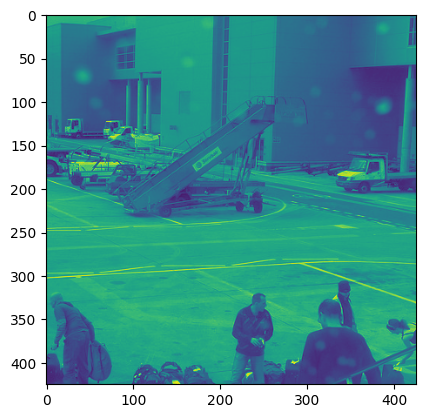

(21025,)


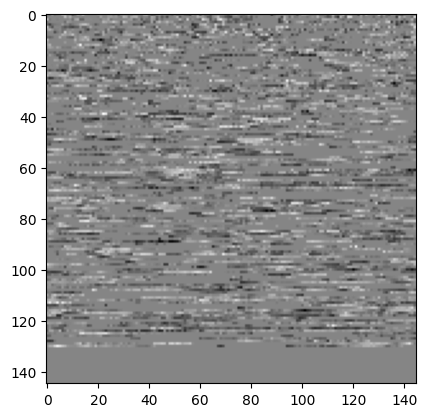

(21025,)


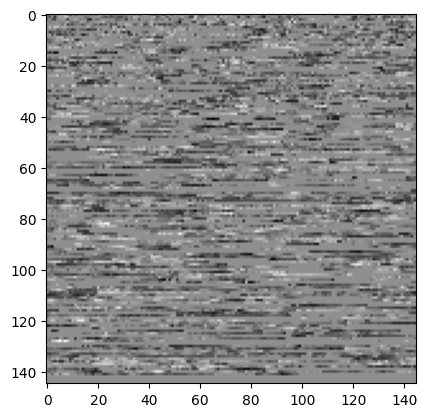

In [22]:
label_test_training_index = random.randint(0, global_labels_train.shape[0] - 1)
print(f'Label test of training data {label_test_training_index}:')
if load_images:
  visualise_data(global_labels_name, global_labels_train[label_test_training_index], global_images_train[label_test_training_index], global_fmri_l_train[label_test_training_index], global_fmri_r_train[label_test_training_index])
else:
    visualise_data(global_labels_name, global_labels_train[label_test_training_index], None, global_fmri_l_train[label_test_training_index], global_fmri_r_train[label_test_training_index])

['person' 'truck' 'backpack' 'suitcase' 'road' 'window-other'
 'sky-other-merged' 'building-other-merged']
(425, 425, 1)


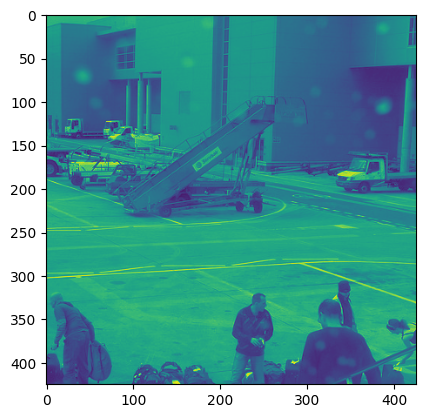

(21025,)


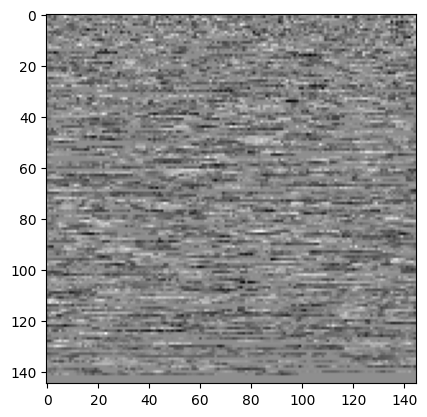

(21025,)


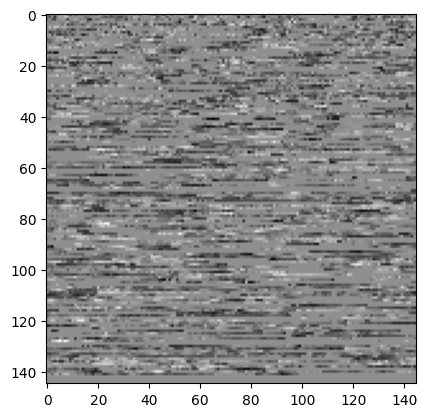

In [23]:
visualise_data(global_labels_name, global_labels_train[label_test_training_index], global_images_train[label_test_training_index], global_fmri_l_train[label_test_training_index]+global_fmri_r_train[label_test_training_index], global_fmri_r_train[label_test_training_index])

In [24]:
from tensorflow import keras

## Preprocess fmri for 1D
using validation set as test set, since the test dataset provided does not have ground truth image

In [25]:
print(f'Combine fmri data train (1D):')

global_X_train_1D = np.concatenate([global_fmri_l_train, global_fmri_r_train], axis=-1)
additional_rows = np.zeros(shape=(global_X_train_1D.shape[0], 42436 - global_X_train_1D.shape[1]))
global_X_train_1D = np.concatenate((global_X_train_1D, additional_rows), axis=1)
print(global_X_train_1D.shape)

print(f'\nCombine fmri data val (1D):')

global_X_test_1D = np.concatenate([global_fmri_l_val, global_fmri_r_val], axis=-1)
additional_rows = np.zeros(shape=(global_X_test_1D.shape[0], 42436 - global_X_test_1D.shape[1]))
global_X_test_1D = np.concatenate((global_X_test_1D, additional_rows), axis=1)
print(global_X_test_1D.shape)





Combine fmri data train (1D):
(4950, 42436)

Combine fmri data val (1D):
(50, 42436)


2023-12-17 05:26:55.761954: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1680465600 exceeds 10% of free system memory.
2023-12-17 05:26:57.955430: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 7152750000 exceeds 10% of free system memory.


(4950, 206, 206, 1)
(50, 206, 206, 1)


(-0.5, 205.5, 205.5, -0.5)

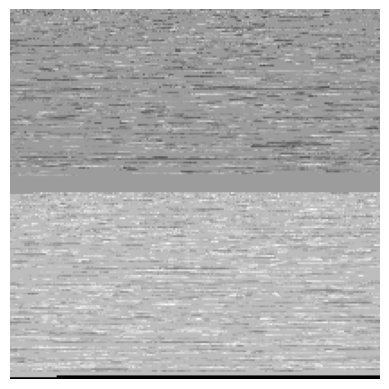

In [26]:
X_train_np = global_X_train_1D.reshape(global_X_train_1D.shape[0], 206, 206, 1)
y_train_np = global_images_train
X_test_np = global_X_test_1D.reshape(global_X_test_1D.shape[0], 206, 206, 1)
y_test_np = global_images_val
X_train_tf = tf.cast(X_train_np, tf.float32)
y_train_tf = tf.cast(y_train_np, tf.float32)
X_test_tf = tf.cast(X_test_np, tf.float32)
y_test_tf = tf.cast(y_test_np, tf.float32)
print(X_train_tf.shape)
print(X_test_tf.shape)
inp = X_train_tf[4]
re = X_train_tf[4]
plt.imshow(X_train_tf[200] / 255.0, cmap = 'gray')
plt.axis('off')

In [27]:
# The facade training set consist of 400 images
BUFFER_SIZE = 206
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 3
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])

  return cropped_image[0], cropped_image[1]
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image


In [28]:

def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 288, 288)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

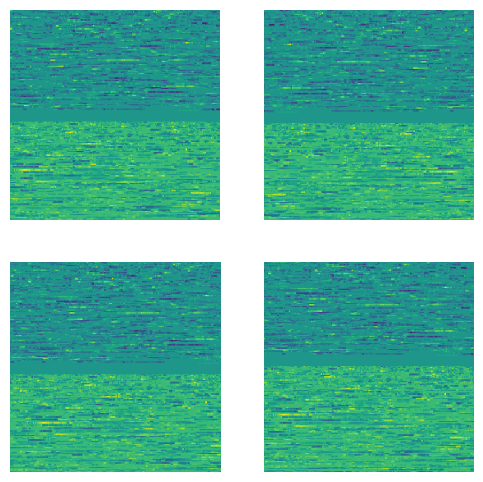

In [29]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(X_train_tf[4], y_train_tf[4])
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [30]:
print(rj_inp.shape, rj_re.shape)

(256, 256, 1) (256, 256, 1)


In [31]:
X_train_dataset = np.zeros((X_train_tf.shape[0], 256,256,1))
y_train_dataset = np.zeros((y_train_tf.shape[0], 256,256,1))
X_test_dataset = np.zeros((X_test_tf.shape[0], 256,256,1))
y_test_dataset = np.zeros((y_test_tf.shape[0], 256,256,1))
for i in range(len(X_train_dataset)):
    train_inp, train_re = random_jitter(X_train_tf[i], y_train_tf[i])
    X_train_dataset[i, :, :, :] = train_inp.numpy()
    y_train_dataset[i, :, :, :] = train_re.numpy()
for i in range(len(X_test_dataset)):
    test_inp, test_re = random_jitter(X_test_tf[i], y_test_tf[i])
    X_test_dataset[i, :, :, :] = test_inp.numpy()
    y_test_dataset[i, :, :, :] = test_re.numpy()
Train_dataset =  tf.data.Dataset.from_tensor_slices((X_train_dataset, y_train_dataset))
Test_dataset =  tf.data.Dataset.from_tensor_slices((X_test_dataset, y_test_dataset))

#free mamory
global_labels_name = None
global_labels_train = None
global_labels_val = None
global_fmri_l_train = None
global_fmri_l_val = None
global_fmri_r_train = None
global_fmri_r_val = None
global_images_train = None
global_images_val = None
global_idx_train = None
global_idx_val = None
X_test_np = None
y_test_np = None

    

2023-12-17 05:27:23.675015: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2595225600 exceeds 10% of free system memory.
2023-12-17 05:27:25.079681: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2595225600 exceeds 10% of free system memory.
2023-12-17 05:27:26.141768: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2595225600 exceeds 10% of free system memory.


## Build the generator

In [55]:
OUTPUT_CHANNELS = 1

In [56]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [57]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(X_train_tf[4], 0))
print (down_result.shape)

(1, 103, 103, 3)


In [58]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [59]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 206, 206, 3)


In [60]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [61]:
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

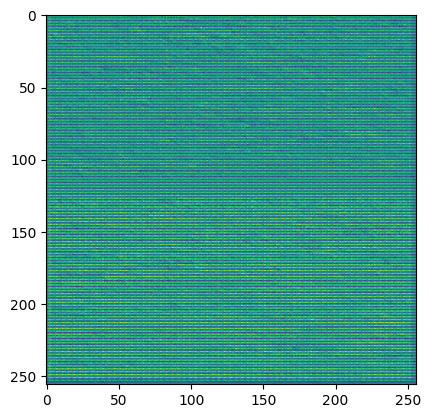

In [62]:
gen_output = generator(rj_inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Define the generator loss

In [63]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [64]:
def generator_loss(disc_generated_output, gen_output, target):
  print(disc_generated_output.dtype, gen_output.dtype,target.dtype)
  print("check3-1")
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  print("check3-2")
  # Mean absolute error
  print(target - gen_output)
  print("check3-3")  
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  print("check3-3")   
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  print(type(total_gen_loss), type(gan_loss), type(l1_loss))
  return total_gen_loss, gan_loss, l1_loss

## Build the discriminator

In [65]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

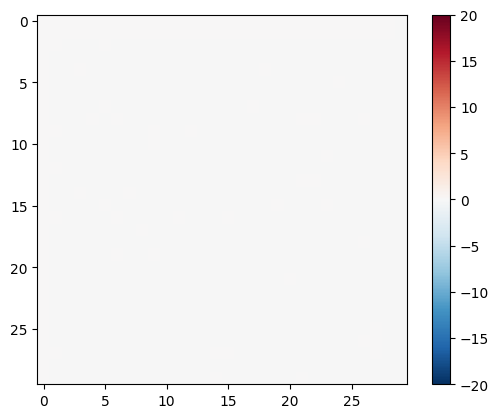

In [66]:
discriminator = Discriminator()
disc_out = discriminator([rj_inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [67]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Define the optimizer and a checkpoint-saver

In [68]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [69]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

In [70]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

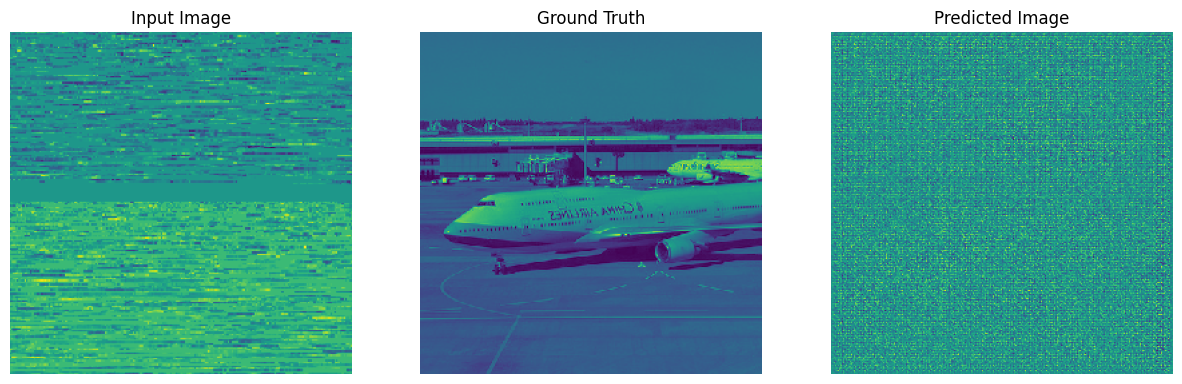

In [71]:
generate_images(generator,rj_inp[tf.newaxis, ...], rj_re[tf.newaxis, ...])

## Training


In [72]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [73]:
@tf.function
def train_step(input_image, target, step):
  input_image = input_image[tf.newaxis, ...]
  target = target[tf.newaxis, ...]
  target = tf.cast(target, dtype=tf.float32)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    print("check1")
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
  
    print("check2")
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    print("check3")
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    print("check4")
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [74]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  # example_input = example_input[tf.newaxis, ...]
  # example_target = example_target[tf.newaxis, ...]
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input[tf.newaxis, ...], example_target[tf.newaxis, ...])
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 18.66 sec



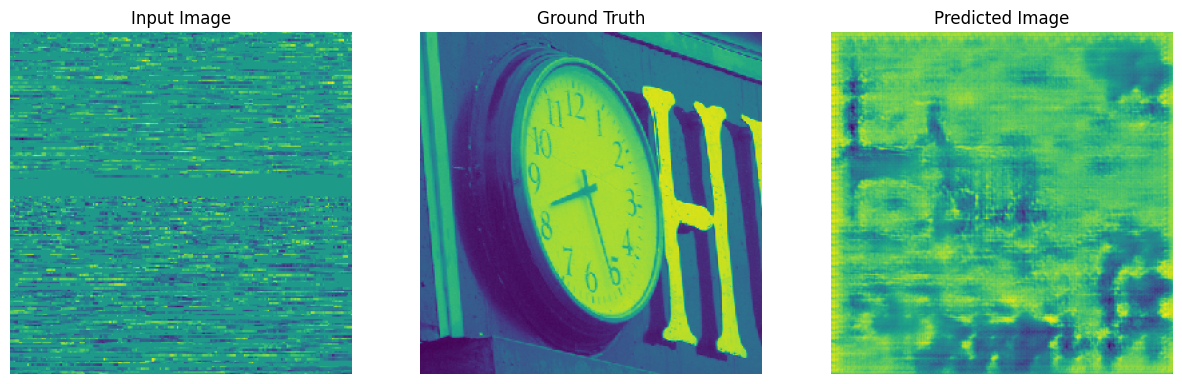

Step: 19k
....................................................................................................

In [75]:
fit(Train_dataset, Test_dataset, steps=20000)

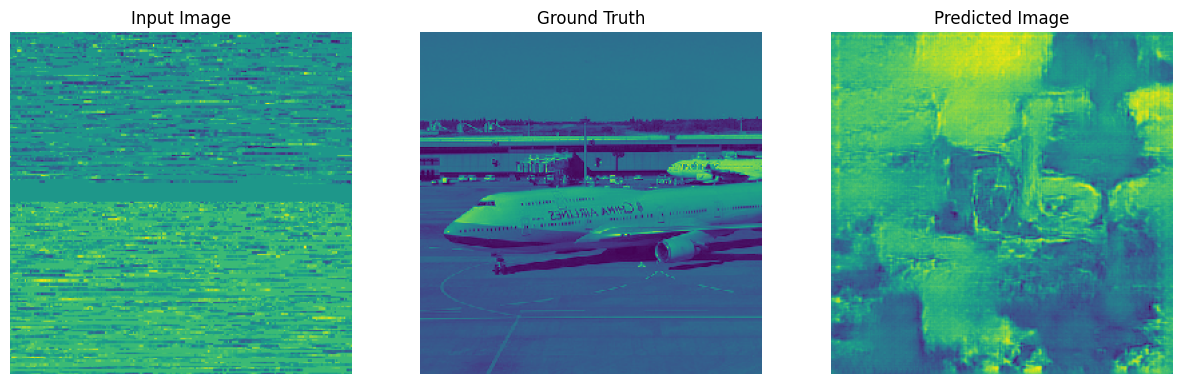

In [76]:
generate_images(generator, rj_inp[tf.newaxis, ...], rj_re[tf.newaxis, ...])

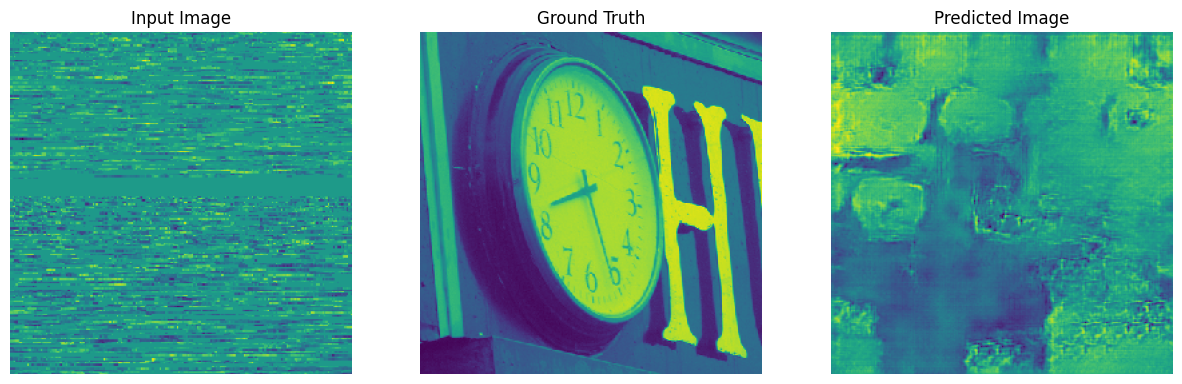

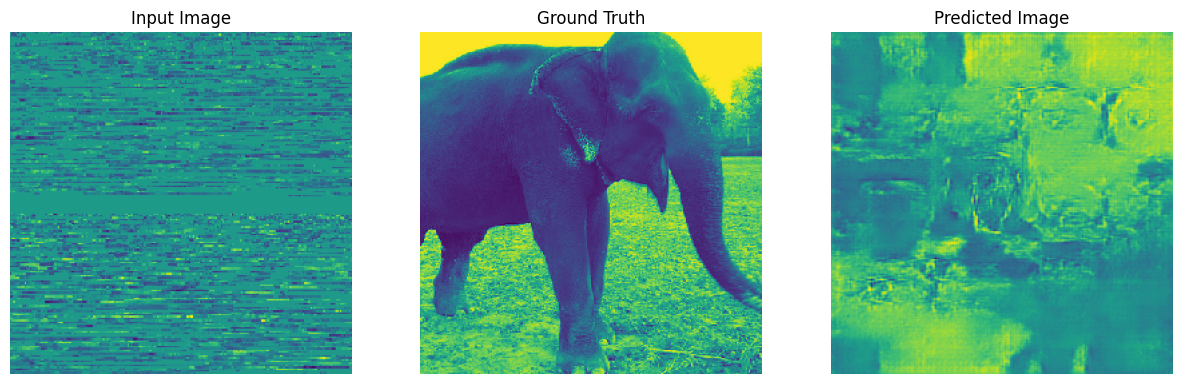

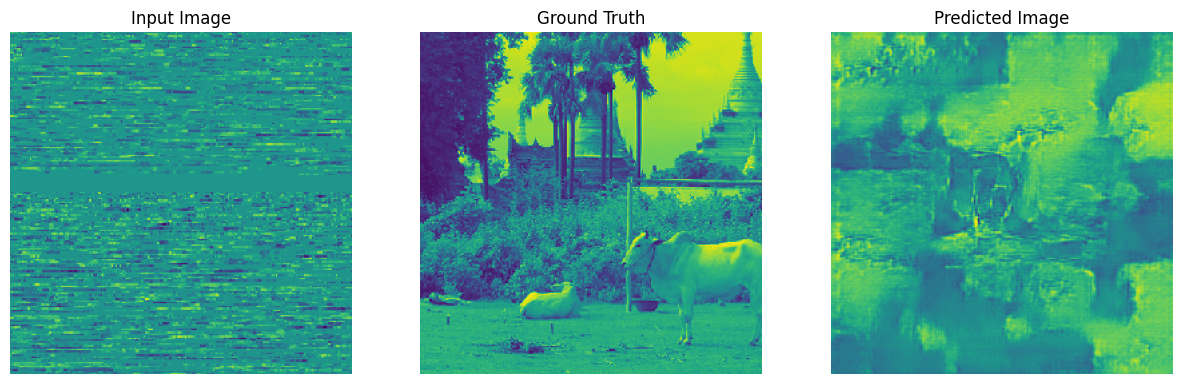

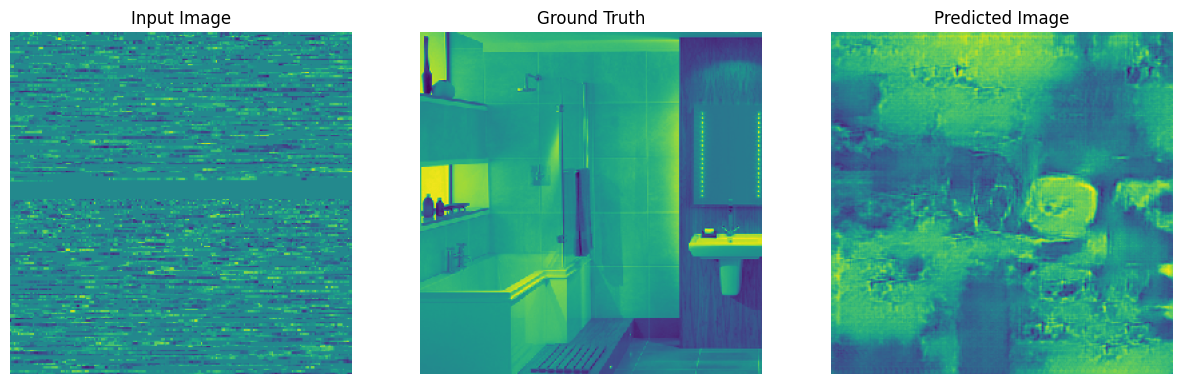

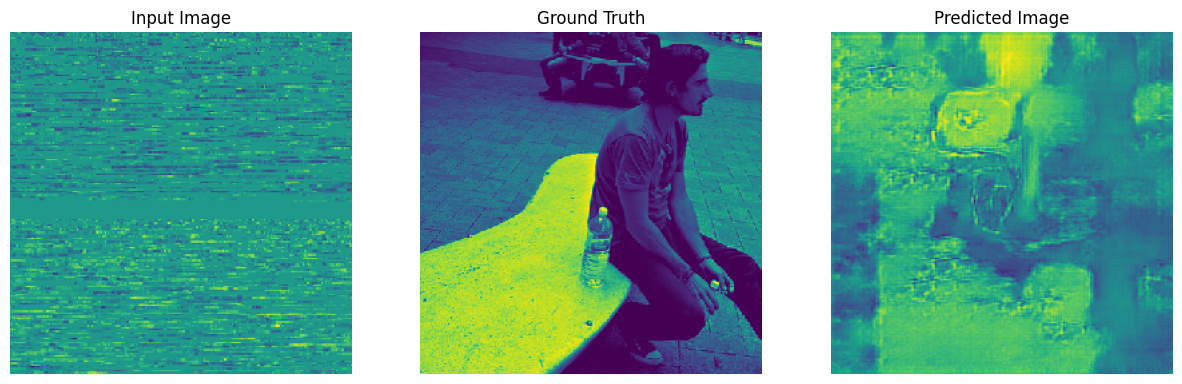

In [83]:
for inp, tar in Test_dataset.take(5):
  generate_images(generator, inp[tf.newaxis, ...], tar[tf.newaxis, ...])